# Multi Objective Optimization 

### Energy Optimization can be treated as a multi-objective optimization problem with the following objectives:
1) Fan Power Consumption
2) Leakage Power 
3) Smoothness Penalty



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import json
from time import time

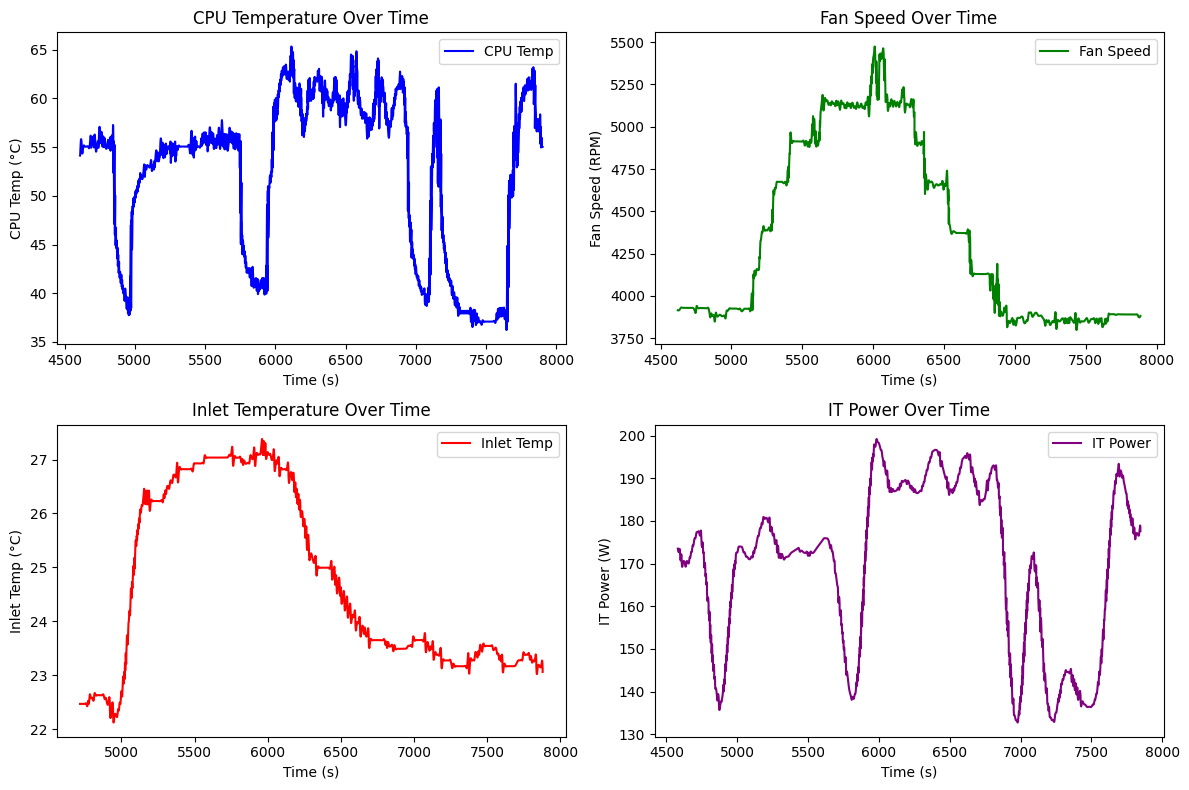

Shape of Final Dataframe = (4255, 5)


In [2]:
cpu_temp = pd.read_csv("../data/cpu-temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/fan-speed.csv", header=None, names=["time", "fan_speed"])
inlet_temp = pd.read_csv("../data/inlet-temp.csv", header=None, names=["time", "inlet_temp"])
it_power = pd.read_csv("../data/it-power.csv", header=None, names=["time", "it_power"])

def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
inlet_temp_new = process_dataframe(inlet_temp, "time", "inlet_temp")
it_power_new = process_dataframe(it_power, "time", "it_power")

def plot_time_series_subplots(cpu_temp_df, fan_speed_df, inlet_temp_df, it_power_df, time_col):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # First subplot - CPU Temperature
    axs[0, 0].plot(cpu_temp_df[time_col], cpu_temp_df['cpu_temp'], color='blue', label='CPU Temp')
    axs[0, 0].set_title('CPU Temperature Over Time')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].set_ylabel('CPU Temp (°C)')
    axs[0, 0].legend()

    # Second subplot - Fan Speed
    axs[0, 1].plot(fan_speed_df[time_col], fan_speed_df['fan_speed'], color='green', label='Fan Speed')
    axs[0, 1].set_title('Fan Speed Over Time')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].set_ylabel('Fan Speed (RPM)')
    axs[0, 1].legend()

    # Third subplot - Inlet Temperature
    axs[1, 0].plot(inlet_temp_df[time_col], inlet_temp_df['inlet_temp'], color='red', label='Inlet Temp')
    axs[1, 0].set_title('Inlet Temperature Over Time')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Inlet Temp (°C)')
    axs[1, 0].legend()

    # Fourth subplot - IT Power
    axs[1, 1].plot(it_power_df[time_col], it_power_df['it_power'], color='purple', label='IT Power')
    axs[1, 1].set_title('IT Power Over Time')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].set_ylabel('IT Power (W)')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


plot_time_series_subplots(cpu_temp_new, fan_speed_new, inlet_temp_new, it_power_new, time_col="time")

max_start = max(inlet_temp_new['time'].min(), cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(inlet_temp_new['time'].max(), cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
inlet_temp_filtered = inlet_temp_new[(inlet_temp_new['time'] >= max_start) & (inlet_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, inlet_temp_filtered, on='time')
combined_df = pd.merge(combined_df, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

# combined_df["cpu_temp_change"] = combined_df["cpu_temp"].diff().fillna(0)
# combined_df["it_power_change"] = combined_df["it_power"].diff().fillna(0)
# combined_df["fan_speed_change"] = combined_df["fan_speed"].diff().fillna(0)
# combined_df["cpu_temp_ma3"] = combined_df["cpu_temp"].rolling(window=3).mean().fillna(combined_df["cpu_temp"])
# combined_df["cpu_temp_std3"] = combined_df["cpu_temp"].rolling(window=3).std().fillna(0)

# print(combined_df.head())

df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

scalers = {
    'cpu_temp': MinMaxScaler(),
    'inlet_temp': MinMaxScaler(),
    'it_power': MinMaxScaler(),
    # 'cpu_temp_change': MinMaxScaler(),
    # 'it_power_change': MinMaxScaler(),
    # 'fan_speed_change': MinMaxScaler(),
    # 'cpu_temp_ma3': MinMaxScaler(),
    # 'cpu_temp_std3': MinMaxScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

min_fan_speed = 0
max_fan_speed = 8000
scale_beta = 5

df_scaled['fan_speed'] = scale_beta * (df['fan_speed'] - min_fan_speed) / (max_fan_speed - min_fan_speed)

# print(df_scaled.head())

def prepare_data(scaled_df, seq_length=8, k_step=24):

    # Define the input and output features
    # features_cols = ['cpu_temp', 'inlet_temp', 'it_power', 'cpu_temp_change', 'it_power_change', 'fan_speed_change', 'cpu_temp_ma3', 'cpu_temp_std3']
    features_cols = ['cpu_temp', 'inlet_temp', 'it_power', 'fan_speed']
    exogenous_col = 'fan_speed'
    output_col = 'cpu_temp'

    # Create sequences
    features = []
    exogenous = []
    outputs = []
    for i in range(len(scaled_df) - seq_length - k_step + 1):
        features.append(scaled_df[features_cols].iloc[i:i + seq_length].values)
        exogenous.append(scaled_df[exogenous_col].iloc[i + seq_length:i + seq_length + k_step].values)
        outputs.append(scaled_df[output_col].iloc[i + seq_length:i + seq_length + k_step].values)

    features = np.array(features)
    exogenous = np.array(exogenous).reshape(-1, k_step, 1)
    outputs = np.array(outputs).reshape(-1, k_step, 1)

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32)
    exogenous = torch.tensor(exogenous, dtype=torch.float32)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    # Split into train and test
    split_ratio = 0.8
    split_index = int(len(features) * split_ratio)
    train_features, test_features = features[:split_index], features[split_index:]
    train_exogenous, test_exogenous = exogenous[:split_index], exogenous[split_index:]
    train_outputs, test_outputs = outputs[:split_index], outputs[split_index:]

    train_dataset = TensorDataset(train_features, train_exogenous, train_outputs)
    test_dataset = TensorDataset(test_features, test_exogenous, test_outputs)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, outputs, split_index

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
import torch
import torch.nn as nn

class DualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_size, k_step, fan_speed_impact_dim=32, fan_speed_impact=2.0):
        super(DualInputAttentionLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.k_step = k_step
        self.input_size = input_size
        self.fan_speed_impact = fan_speed_impact

        # LSTM and Attention
        self.lstm_attention = nn.MultiheadAttention(lstm_hidden_size, num_heads=1, batch_first=True)
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)

        # Fan speed impact through an MLP (No ReLU to allow negative values)
        self.fan_speed_mlp = nn.Sequential(
            nn.Linear(k_step, fan_speed_impact_dim),  
            nn.Tanh(),  
            nn.Linear(fan_speed_impact_dim, lstm_hidden_size)  
        )

        # Fully connected layers
        self.dense1 = nn.Linear(lstm_hidden_size * 2, dense_hidden_size)  
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_hidden_size, k_step)

    def forward(self, x, exogenous_input_fan_speed):
        batch_size, seq_len, feature_dim = x.shape

        # print(f"x.shape = {x.shape}")
        # print(f"exogenous_input_fan_speed.shape = {exogenous_input_fan_speed.shape}")

        # LSTM Processing
        h_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        c_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        lstm_out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        attn_output, _ = self.lstm_attention(lstm_out, lstm_out, lstm_out)
        lstm_features = attn_output[:, -1, :]  # Shape: (batch_size, lstm_hidden_size)

        # Process fan speed as an array of shape (batch_size, k_step)
        fan_speed_transformed = self.fan_speed_impact / (exogenous_input_fan_speed.squeeze(-1) + 1e-6)  # Avoid division by zero
        fan_speed_effect = self.fan_speed_mlp(fan_speed_transformed.squeeze(-1))  # Shape: (batch_size, lstm_hidden_size)
 
        # Concatenate features
        combined_features = torch.cat((lstm_features, fan_speed_effect), dim=1)  

        # Fully Connected Layers
        dense1_out = self.relu(self.dense1(combined_features))
        outputs = self.dense2(dense1_out)

        return outputs


In [5]:
def train_model(model, train_loader, test_loader, k_step, learning_rate=0.001, num_epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

    history = {'train_loss': [], 'test_loss': []}

    # Function to compute loss
    def evaluate_loss(loader, model):
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_features, batch_exogenous, batch_outputs in loader:
                batch_exogenous = batch_exogenous.unsqueeze(-1)  # Ensure correct shape for fan speed
                outputs = model(batch_features, batch_exogenous)
                loss = criterion(outputs, batch_outputs.squeeze(-1))  # Fix dimension mismatch
                total_loss += loss.item()
        return total_loss / len(loader)

    train_loss = evaluate_loss(train_loader, model)
    test_loss = evaluate_loss(test_loader, model)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    print(f"Before Training: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    # wandb.log({"epoch": 0, "train_loss": train_loss, "test_loss": test_loss})

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_features, batch_exogenous, batch_outputs in train_loader:
            batch_exogenous = batch_exogenous.unsqueeze(-1)  # Ensure correct shape for fan speed
            
            optimizer.zero_grad()
            outputs = model(batch_features, batch_exogenous)
            loss = criterion(outputs, batch_outputs.squeeze(-1))  # Fix dimension mismatch
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Evaluate test loss
        test_loss = evaluate_loss(test_loader, model)
        history['test_loss'].append(test_loss)

        # Adjust learning rate
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        # wandb.log({"epoch": epoch+1, "train_loss": train_loss, "test_loss": test_loss})

    return model, history


In [6]:
import torch
import numpy as np
from sklearn.metrics import r2_score, root_mean_squared_error

def evaluate_model_original(model, data_loader, scaler, k_step):
    model.eval()
    all_actuals = []
    all_predictions = []

    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in data_loader:
            batch_exogenous = batch_exogenous.unsqueeze(-1)  # Ensure correct shape for fan speed
            
            outputs = model(batch_features, batch_exogenous)
            actual_values = batch_outputs.squeeze(-1)  # Shape: (batch_size, k_step)
            
            # Apply inverse transform
            outputs_original = scaler.inverse_transform(outputs.cpu().numpy())
            actual_original = scaler.inverse_transform(actual_values.cpu().numpy())

            # Store predictions and actuals
            all_actuals.append(actual_original)
            all_predictions.append(outputs_original)

    # Convert lists to arrays
    all_actuals = np.concatenate(all_actuals, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    # Compute overall RMSE
    avg_rmse = root_mean_squared_error(all_actuals, all_predictions)

    # Compute overall R²
    avg_r2 = r2_score(all_actuals.flatten(), all_predictions.flatten())
    
    print(f"Average R² Score: {avg_r2:.4f}")
    print(f"Average RMSE: {avg_rmse:.4f}")
    
    return avg_r2, avg_rmse


In [7]:
seq_length = 15
k_step = 15
input_size = 4 # cpu_temp, inlet_temp, it_power
lstm_hidden_size = 64
dense_hidden_size = 64
learning_rate = 0.001
num_epochs = 25

In [8]:
train_loader, test_loader, outputs, split_index = prepare_data(df_scaled, seq_length, k_step)
model = DualInputAttentionLSTM(input_size, lstm_hidden_size, dense_hidden_size, k_step, fan_speed_impact=-1)
trained_model, history = train_model(model, train_loader, test_loader, k_step, learning_rate, num_epochs)

Before Training: Train Loss: 0.4466, Test Loss: 0.2030
Epoch 1/25, Train Loss: 0.0807, Test Loss: 0.0165
Epoch 2/25, Train Loss: 0.0044, Test Loss: 0.0060
Epoch 3/25, Train Loss: 0.0035, Test Loss: 0.0045
Epoch 4/25, Train Loss: 0.0035, Test Loss: 0.0044
Epoch 5/25, Train Loss: 0.0036, Test Loss: 0.0046
Epoch 6/25, Train Loss: 0.0033, Test Loss: 0.0043
Epoch 7/25, Train Loss: 0.0032, Test Loss: 0.0042
Epoch 8/25, Train Loss: 0.0032, Test Loss: 0.0044
Epoch 9/25, Train Loss: 0.0032, Test Loss: 0.0041
Epoch 10/25, Train Loss: 0.0033, Test Loss: 0.0039
Epoch 11/25, Train Loss: 0.0032, Test Loss: 0.0041
Epoch 12/25, Train Loss: 0.0031, Test Loss: 0.0040
Epoch 13/25, Train Loss: 0.0032, Test Loss: 0.0039
Epoch 14/25, Train Loss: 0.0032, Test Loss: 0.0040
Epoch 15/25, Train Loss: 0.0031, Test Loss: 0.0040
Epoch 16/25, Train Loss: 0.0031, Test Loss: 0.0039
Epoch 17/25, Train Loss: 0.0031, Test Loss: 0.0040
Epoch 18/25, Train Loss: 0.0031, Test Loss: 0.0041
Epoch 19/25, Train Loss: 0.0031, Tes

In [9]:
r2, rmse = evaluate_model_original(trained_model, test_loader, scalers["cpu_temp"], k_step)

Average R² Score: 0.9569
Average RMSE: 1.8448


In [10]:
def plot_forecasts(actual_predictions, modified_predictions, actuals, k_step):
    for i in range(k_step):
        plt.figure(figsize=(12, 6))
        plt.plot(actuals[:, i], label=f'Actual CPU Temp', color='blue', alpha=0.6)
        plt.plot(actual_predictions[:, i], label=f'Predicted (Original Fan Speed)', color='red')
        plt.plot(modified_predictions[:, i], label=f'Predicted (Modified Fan Speed)', color='green')

        plt.xlabel('Time Step', fontsize=14)
        plt.ylabel('CPU Temperature (°C)', fontsize=14)
        plt.title(f'Forecast Step {i+1}', fontsize=16)
        plt.legend(fontsize=12)
        plt.show()

In [11]:
def demo_modified_fan_loop(model, test_loader, scaler, k_step, modified_fan_speeds):
    model.eval()
    
    actual_predictions = []
    modified_predictions_dict = {scale: [] for scale in modified_fan_speeds}
    actuals = []
    
    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:
            
            # Original Predictions
            actual_output = model(batch_features, batch_exogenous)
            actual_predictions.append(actual_output.cpu().numpy())
            
            for scale in modified_fan_speeds:
                modified_exogenous = batch_exogenous.clone()
                modified_exogenous[:, :, -1] = torch.clamp(modified_exogenous[:, :, -1] * scale, max=scale_beta)  # Scale fan_speed
                modified_output = model(batch_features, modified_exogenous)
                modified_predictions_dict[scale].append(modified_output.cpu().numpy())
                
            # Store actual values
            actuals.append(batch_outputs.cpu().numpy())

    actual_predictions = np.concatenate(actual_predictions, axis=0)  # (num_samples, k_step)
    actuals = np.concatenate(actuals, axis=0).squeeze(axis=2)  # (num_samples, k_step)
    
    for scale in modified_fan_speeds:
        modified_predictions_dict[scale] = np.concatenate(modified_predictions_dict[scale], axis=0)
    
    # Inverse scale predictions and actuals
    for i in range(k_step):
        actual_predictions[:, i] = scaler.inverse_transform(actual_predictions[:, i].reshape(-1, 1)).flatten()
        actuals[:, i] = scaler.inverse_transform(actuals[:, i].reshape(-1, 1)).flatten()
        
        for scale in modified_fan_speeds:
            modified_predictions_dict[scale][:, i] = scaler.inverse_transform(
                modified_predictions_dict[scale][:, i].reshape(-1, 1)).flatten()
    
    return actual_predictions, modified_predictions_dict, actuals

def plot_forecasts_loop(actual_predictions, modified_predictions_dict, actuals, k_step, modified_fan_speeds):
    colors = plt.cm.viridis(np.linspace(0, 1, len(modified_fan_speeds)))
    
    for i in range(k_step):
        plt.figure(figsize=(12, 6))
        plt.plot(actuals[:, i], label=f'Actual CPU Temp', color='blue', alpha=0.6)
        plt.plot(actual_predictions[:, i], label=f'Predicted (Original Fan Speed)', color='red')
        
        for scale, color in zip(modified_fan_speeds, colors):
            plt.plot(modified_predictions_dict[scale][:, i], label=f'Predicted (Fan Speed x{scale})', color=color)
        
        plt.xlabel('Time Step', fontsize=14)
        plt.ylabel('CPU Temperature (°C)', fontsize=14)
        plt.title(f'Forecast Step {i+1}', fontsize=16)
        plt.legend(fontsize=12)
        plt.show()


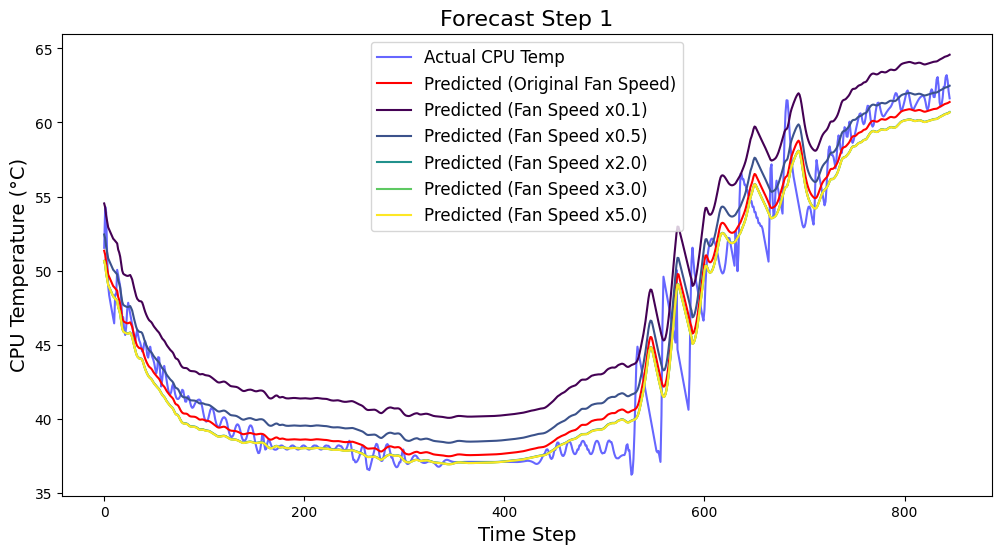

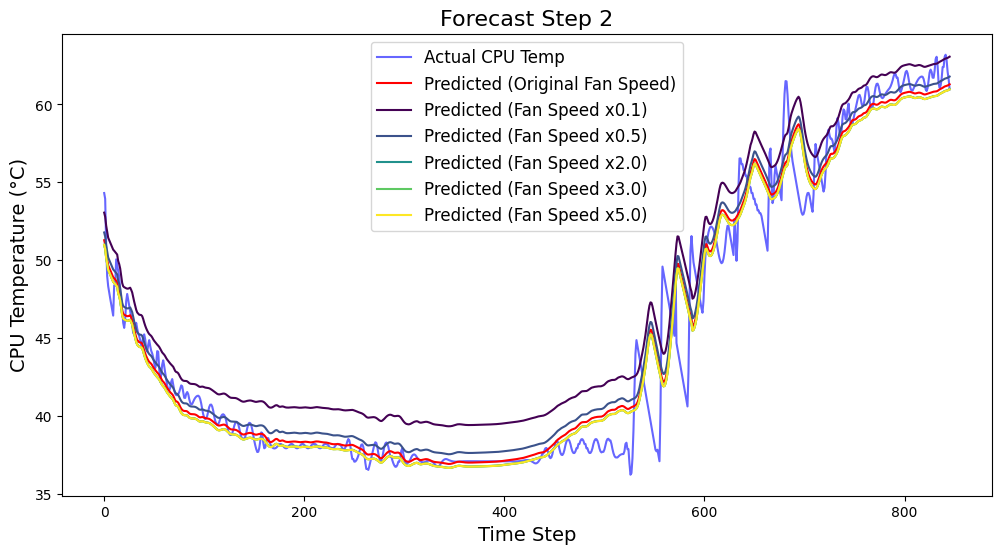

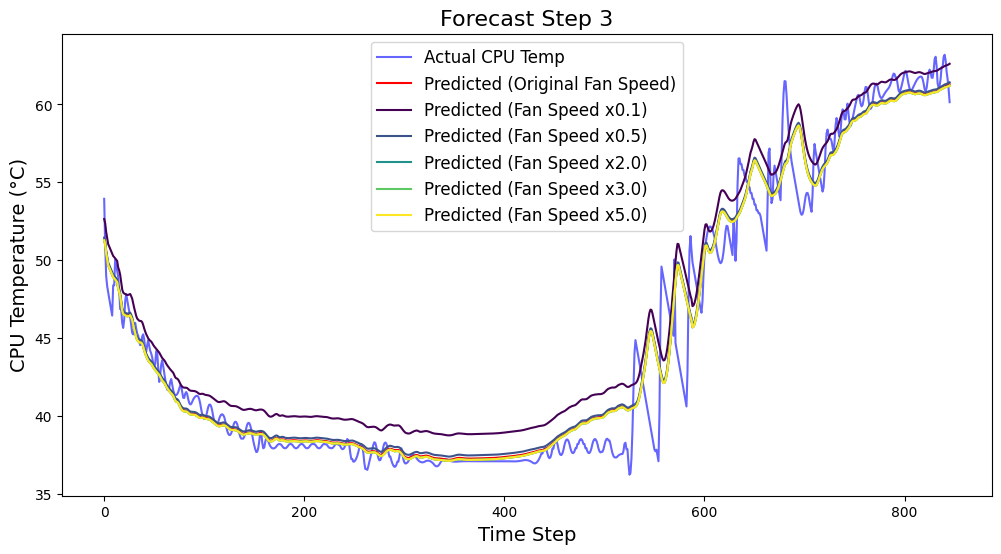

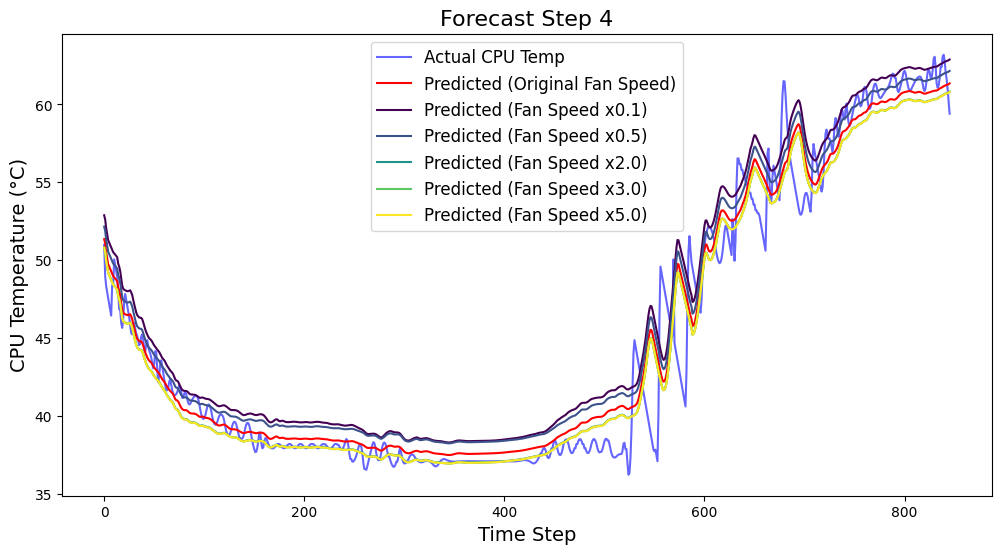

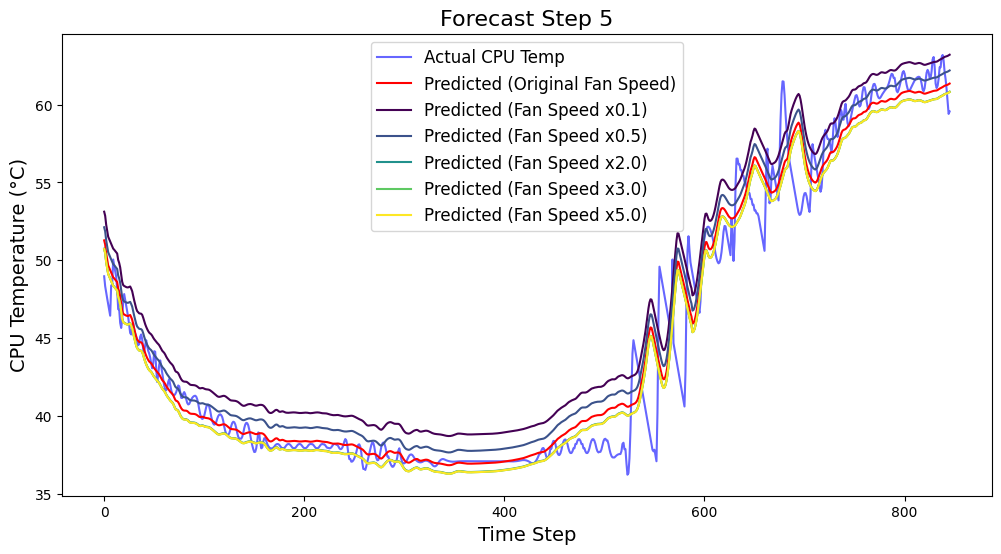

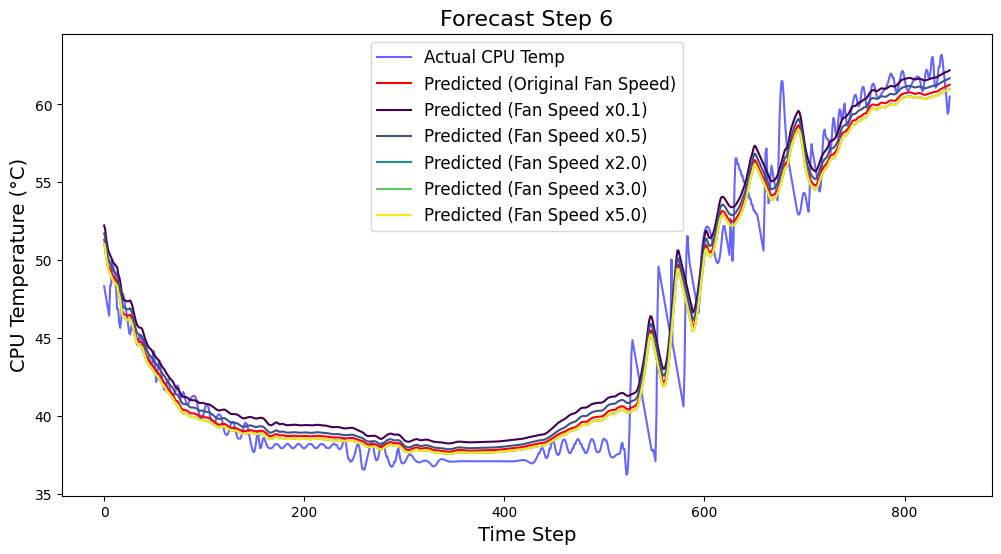

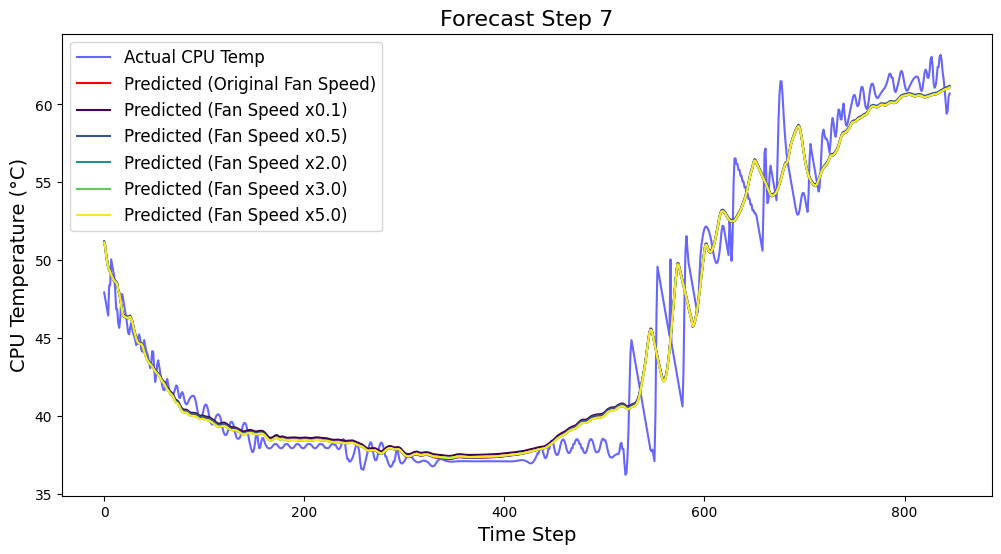

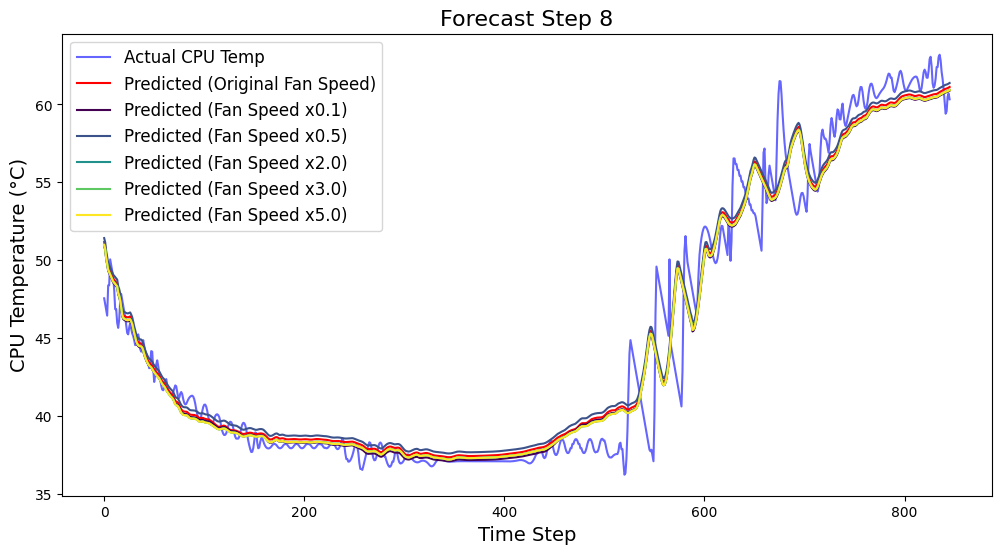

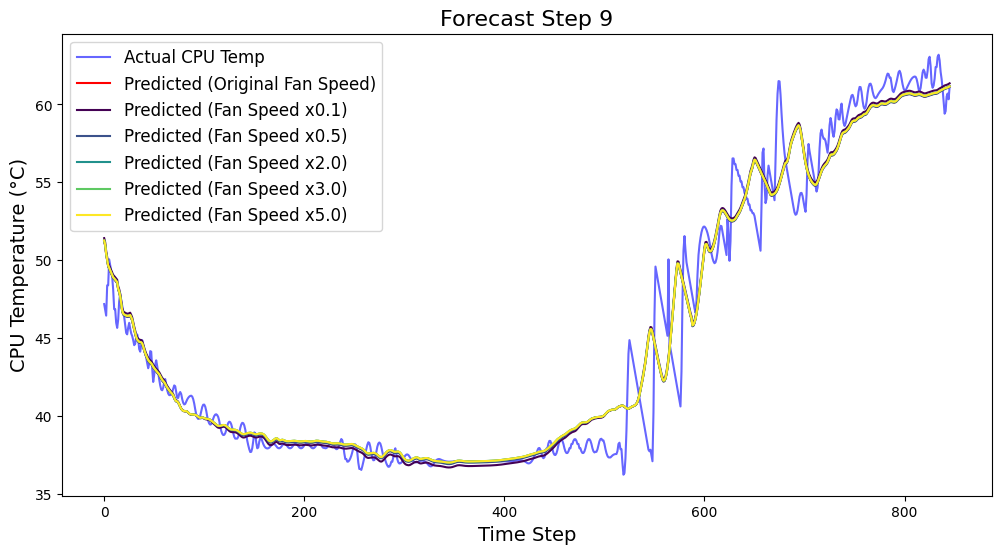

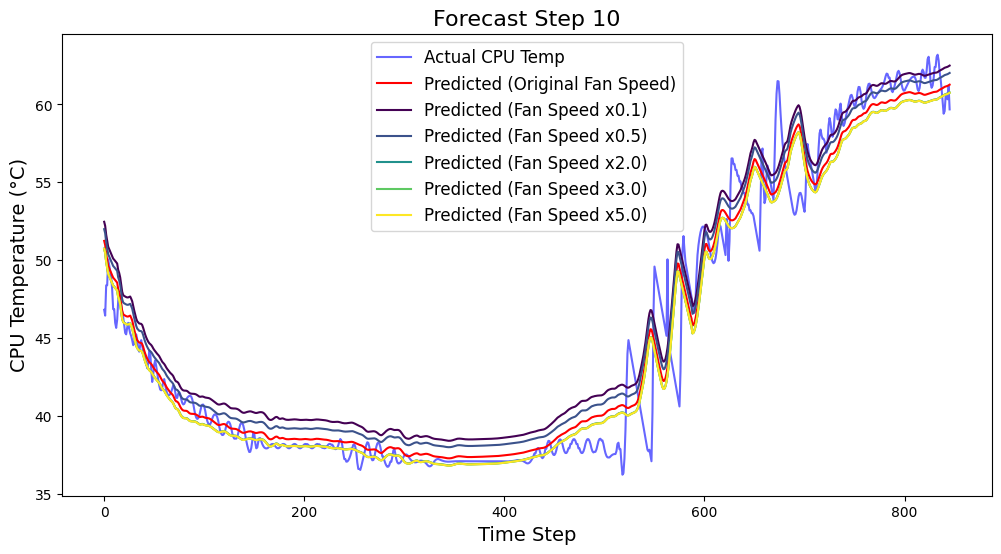

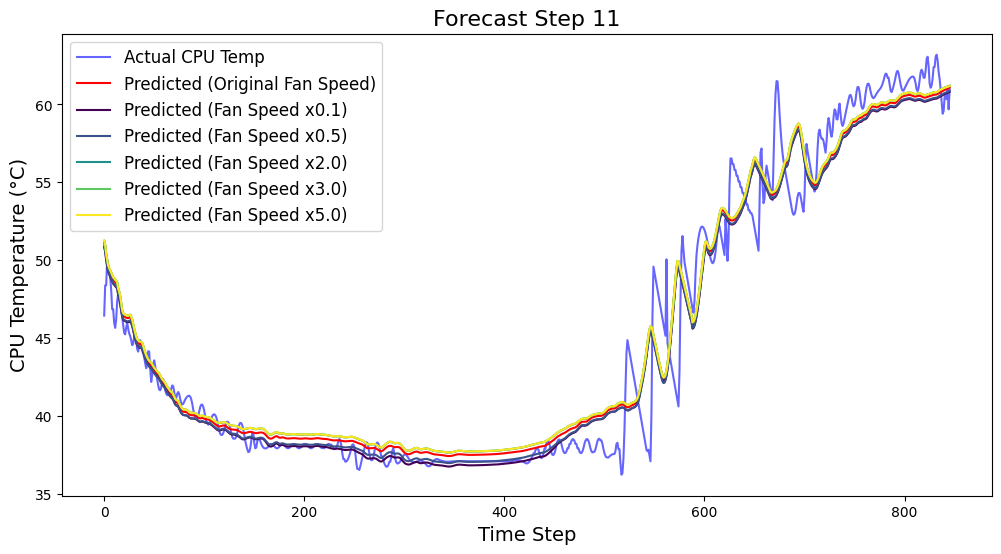

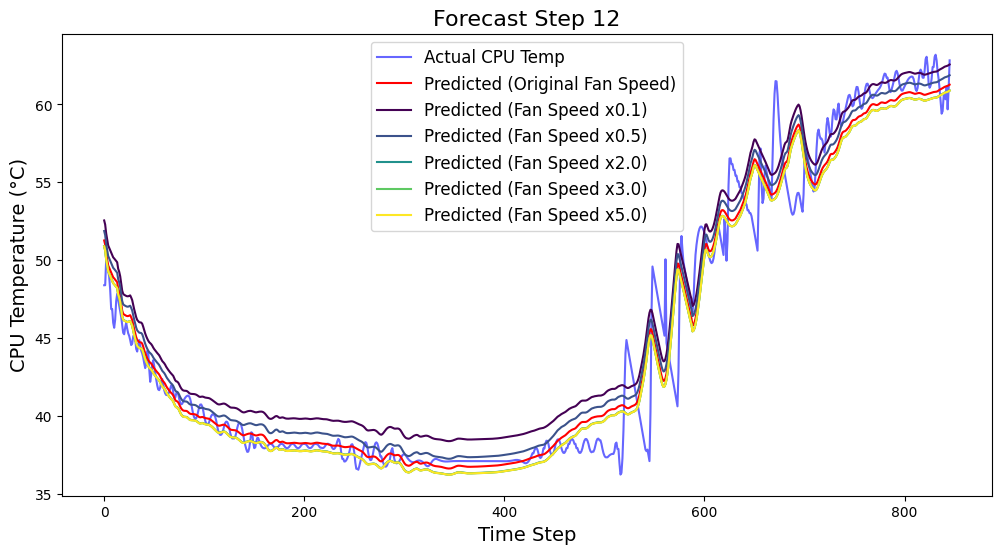

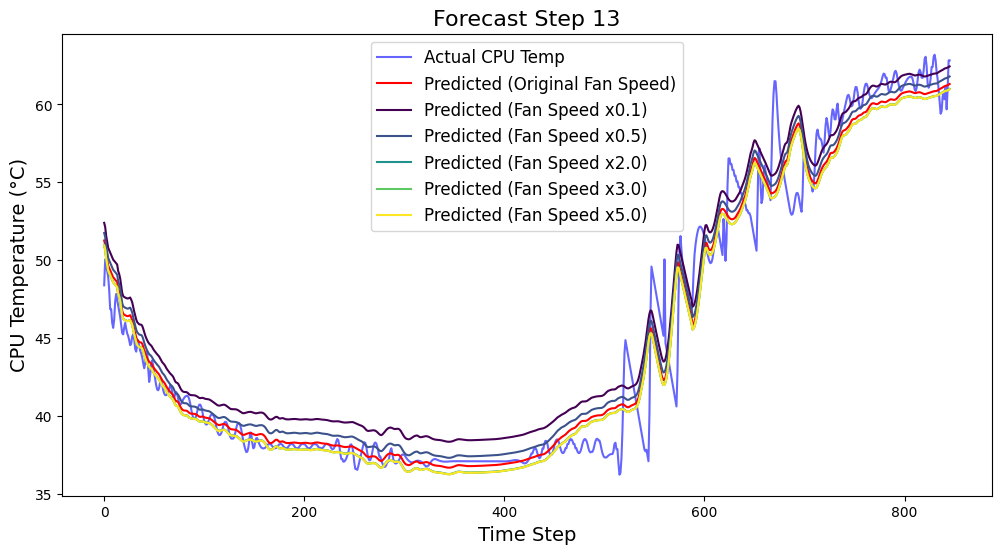

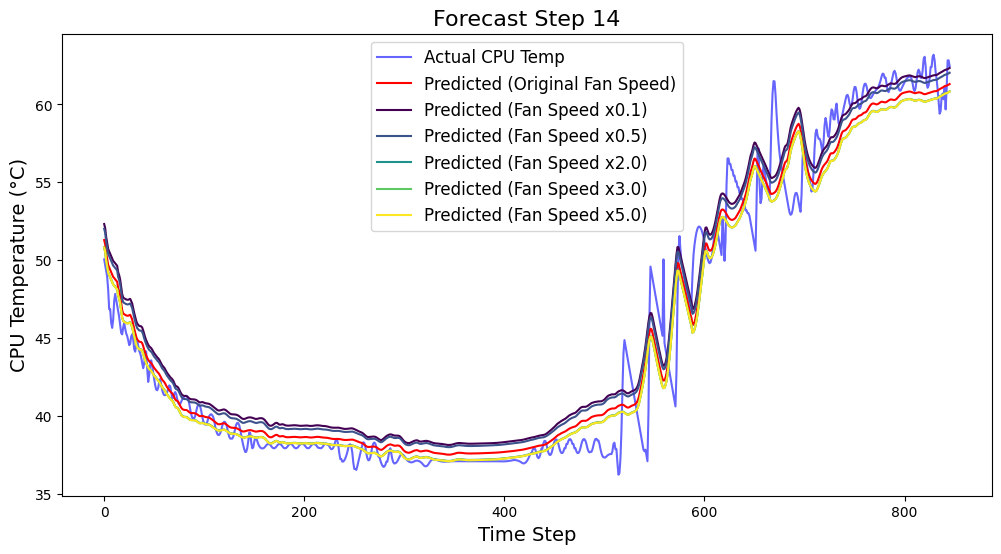

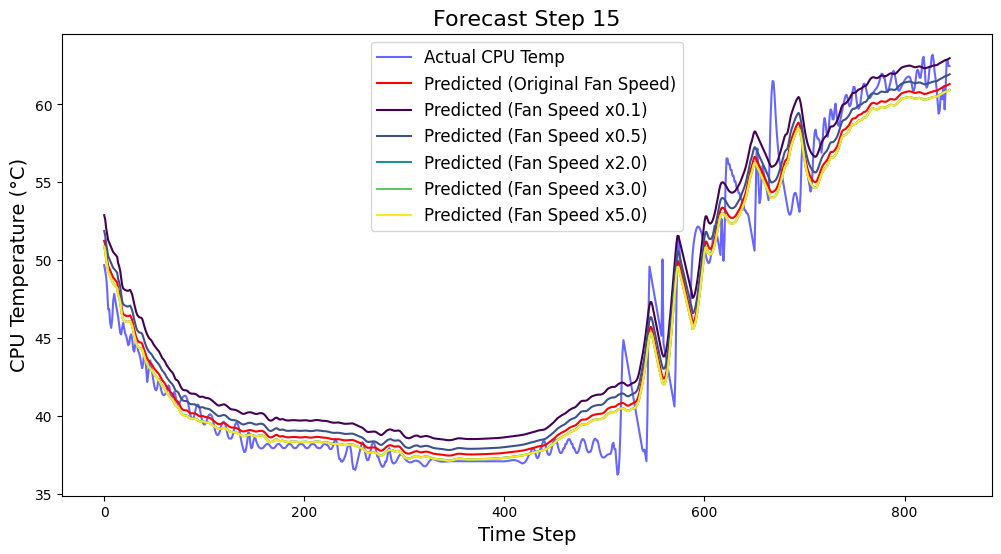

In [12]:
modified_fan_speeds = [0.1, 0.5, 2.0, 3.0, 5.0]

actual_preds_dict, modified_preds_dict, actuals = demo_modified_fan_loop(model, test_loader, scalers["cpu_temp"], k_step, modified_fan_speeds)
plot_forecasts_loop(actual_preds_dict, modified_preds_dict, actuals, k_step, modified_fan_speeds)

In [13]:
def energy_consumption(temperature, fan_speed):
    leakage_power = 0
    fan_power = 0

    for v in fan_speed:
        fan_power += (-0.05 * (v**3) + 7.20 * (v**2) + 1.68 * v + 6.44)

    for t in temperature:
        leakage_power += (-4.114 + 13.871 * np.exp(1.096 * t))

    total_power = leakage_power + fan_power
    if not np.isfinite(total_power):
        return 1e8
    
    return total_power, fan_power, leakage_power

## Optimization Module

In [14]:
from deap import base, creator, tools, algorithms
import random
import torch
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [15]:
T_safe_lim = 65

In [16]:
def constraint_fn(fan_speeds, forecast_temps, temp_limit=T_safe_lim):  
    return all(temp <= temp_limit for temp in forecast_temps)

def get_forecast_temp(model, data_sample, fan_speeds):
    model.eval()
    with torch.no_grad():
        features, _, _ = data_sample
        fan_speeds_tensor = torch.tensor(fan_speeds, dtype=torch.float32).unsqueeze(0)
        output = model(features.unsqueeze(0), fan_speeds_tensor)
    return output.squeeze(0).tolist()

def objective_fn(fan_speeds, forecast_temp):
    """
    Objective function to minimize total energy consumption.
    """

    total_power, fan_power, leakage_power = energy_consumption(forecast_temp, fan_speeds)
    return total_power, fan_power, leakage_power

In [17]:
# Implements NSGA II algorithm for optimization

if not hasattr(creator, "FitnessMulti"):
    creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0))  # All objectives minimized
    creator.create("Individual", list, fitness=creator.FitnessMulti)

In [18]:
def evaluate_nsga2(individual, model, data_sample, v_t, lambda_param):
    new_fan_speeds = [max(0, min(5, alpha * v_t)) for alpha in individual]
    forecast_temps = get_forecast_temp(model, data_sample, new_fan_speeds)

    if not constraint_fn(new_fan_speeds, forecast_temps):
        return (float('inf'), float('inf'), float('inf'))

    _, fan_power, leakage_power = energy_consumption(forecast_temps, new_fan_speeds)
    smoothness_penalty = sum((new_fan_speeds[i+1] - new_fan_speeds[i])**2 for i in range(len(new_fan_speeds)-1))

    return fan_power, leakage_power, lambda_param * smoothness_penalty

In [19]:
def get_optimal_fan_speed_nsga2(model, data_sample, k_step, generations=50, population_size=40, lambda_param=30):
    v_t = data_sample[1][-1].item()
    
    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, 0.5, 2.0)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=k_step)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=1.0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selNSGA2)
    toolbox.register("evaluate", lambda ind: evaluate_nsga2(ind, model, data_sample, v_t, lambda_param))

    population = toolbox.population(n=population_size)
    hof = tools.ParetoFront()

    algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=population_size,
                              cxpb=0.5, mutpb=0.2, ngen=generations,
                              stats=None, halloffame=hof, verbose=False)

    best_individual = min(hof, key=lambda ind: sum(ind.fitness.values))
    optimal_fan_speeds = [max(0, min(5, alpha * v_t)) for alpha in best_individual]

    return optimal_fan_speeds, hof

In [35]:
def plot_pareto_front(hof):
    fan_powers = []
    leakage_powers = []
    smooth_penalties = []

    for ind in hof:
        fan_powers.append(ind.fitness.values[0])
        leakage_powers.append(ind.fitness.values[1])
        smooth_penalties.append(ind.fitness.values[2])

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(fan_powers, leakage_powers, smooth_penalties, c='r', marker='o')

    ax.set_xlabel('Fan Power')
    ax.set_ylabel('Leakage Power')
    ax.set_zlabel('Smoothness Penalty')
    ax.set_title('Pareto Front: NSGA-II Optimization')
    plt.tight_layout()
    plt.show()


In [36]:
def run_optimization(model, test_loader, method="nsga2", generations=20, population_size=30, lambda_smooth=30):
    results = {}
    sample = 0
    time_taken = []

    for batch in test_loader:
        for i in range(batch[0].shape[0]): 
            data_sample = (batch[0][i], batch[1][i], batch[2][i]) 
            original_fan_speeds = data_sample[1] 

            original_energy, orig_fan_power, orig_leakage_power = objective_fn(
                original_fan_speeds, data_sample[0][:, 0].tolist()
            )

            start_time = time()
            if method == "nsga2":
                optimal_fan_speeds, hof = get_optimal_fan_speed_nsga2(
                    model, data_sample, k_step=len(original_fan_speeds),
                    generations=generations, population_size=population_size,
                    lambda_param=lambda_smooth
                )
                if sample == 0:
                    plot_pareto_front(hof)
            end_time = time()

            time_taken.append(end_time - start_time)

            optimized_forecast_temps = get_forecast_temp(model, data_sample, optimal_fan_speeds)
            optimized_energy, opt_fan_power, opt_leakage_power = objective_fn(optimal_fan_speeds, optimized_forecast_temps)

            sample += 1
            print(f"Running Optimization for sample {sample}/864...")

            results[sample] = {
                "original_fan_speeds": original_fan_speeds,
                "original_temperatures": data_sample[0][:, 0].tolist(),
                "original_energy": original_energy,
                "original_fan_power": orig_fan_power,
                "original_leakage_power": orig_leakage_power,
                "optimized_fan_speeds": optimal_fan_speeds,
                "optimized_temperatures": optimized_forecast_temps,
                "optimized_energy": optimized_energy,
                "optimized_fan_power": opt_fan_power,
                "optimized_leakage_power": opt_leakage_power,
            }

    return results, time_taken


In [37]:
def convert_tensors(obj):
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_tensors(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_tensors(v) for v in obj]
    return obj

In [38]:
def convert_results_for_plotting(results, k_step, scaler):
    """
    Convert the results dictionary into a format suitable for plotting step-wise comparisons.
    Apply inverse transformation using the provided scaler.
    """
    actuals = []
    optimized_predictions = []
    
    for sample, data in results.items():
        original_temps = scaler.inverse_transform(np.array(data["original_temperatures"]).reshape(-1, 1)).flatten()
        optimized_temps = scaler.inverse_transform(np.array(data["optimized_temperatures"]).reshape(-1, 1)).flatten()
        
        actuals.append(original_temps[:k_step])
        optimized_predictions.append(optimized_temps[:k_step])
    
    return np.array(actuals), np.array(optimized_predictions)

def plot_optimization_forecasts(results, k_step):
    """
    Plots original vs. optimized CPU temperatures for each forecast step across all samples.
    """
    actuals, optimized_predictions = convert_results_for_plotting(results, k_step, scalers["cpu_temp"])
    
    for i in range(k_step):
        plt.figure(figsize=(12, 6))
        plt.plot(actuals[:, i], label=f'Actual CPU Temp', color='blue', alpha=0.6)
        plt.plot(optimized_predictions[:, i], label=f'Optimized CPU Temp', color='red')
        
        plt.xlabel('Sample Index', fontsize=14)
        plt.ylabel('CPU Temperature (°C)', fontsize=14)
        plt.title(f'Forecast Step {i+1}', fontsize=16)
        plt.legend(fontsize=12)
        plt.show()


In [39]:
def compute_energy_savings(results):

    total_optimized_energy = 0
    total_original_energy = 0

    total_original_fan_power = 0
    total_optimized_fan_power = 0   

    total_original_leakage_power = 0
    total_optimized_leakage_power = 0

    for i in range(len(results)):
        total_original_energy += results[i+1]["original_energy"][0]
        total_optimized_energy += results[i+1]["optimized_energy"]

        total_original_fan_power += results[i+1]["original_fan_power"][0]
        total_optimized_fan_power += results[i+1]["optimized_fan_power"]

        total_original_leakage_power += results[i+1]["original_leakage_power"]
        total_optimized_leakage_power += results[i+1]["optimized_leakage_power"]
    
    energy_savings_percentage = ((total_original_energy - total_optimized_energy) / total_original_energy) * 100
    fan_power_savings_percentage = ((total_original_fan_power - total_optimized_fan_power) / total_original_fan_power) * 100
    leakage_power_savings_percentage = ((total_original_leakage_power - total_optimized_leakage_power) / total_original_leakage_power) * 100

    print(f"Total Energy Savings: {energy_savings_percentage:.2f}%")
    print(f"Total Fan Power Savings: {fan_power_savings_percentage:.2f}%")
    print(f"Total Leakage Power Savings: {leakage_power_savings_percentage:.2f}%")

    return energy_savings_percentage

In [40]:
def compute_fluctuation_score(fan_speeds_list):
    fluctuation_scores = []

    for speeds in fan_speeds_list:
        speeds = np.array(speeds).flatten()
        fluctuation = np.sum(np.abs(np.diff(speeds)))
        fluctuation_scores.append(fluctuation)

    avg_fluctuation_score = np.mean(fluctuation_scores)
    return avg_fluctuation_score

In [ ]:
lambda_params = [1]
tuning_results = {}

for lambda_param in lambda_params:
    print(f"Running optimization with lambda_smooth = {lambda_param}...")
    tuning_results[lambda_param] = {}
    
    # Run optimization using NSGA-II
    results, time_taken = run_optimization(model, test_loader, method="nsga2", generations=20, population_size=30, lambda_smooth=lambda_param)
    
    # Convert tensors to lists/dicts
    results = convert_tensors(results)
    
    # Store results and metadata
    tuning_results[lambda_param]["results"] = results
    tuning_results[lambda_param]["time_taken"] = time_taken
    tuning_results[lambda_param]["energy_savings"] = compute_energy_savings(results)

    # Extract optimized fan speeds
    optimal_fan_speeds = []
    fan_power_list = []
    leakage_power_list = []
    smoothness_list = []

    for sample, data in results.items():
        fan_speeds = data["optimized_fan_speeds"]
        optimal_fan_speeds.append(fan_speeds)

        # Collect individual objectives for plotting or analysis
        fan_power_list.append(data["optimized_fan_power"])
        leakage_power_list.append(data["optimized_leakage_power"])
        smoothness = sum((fan_speeds[i+1] - fan_speeds[i])**2 for i in range(len(fan_speeds)-1))
        smoothness_list.append(smoothness)

    # Save for plotting Pareto front
    tuning_results[lambda_param]["pareto_front"] = {
        "fan_power": fan_power_list,
        "leakage_power": leakage_power_list,
        "smoothness_penalty": smoothness_list
    }

    # Fluctuation score
    tuning_results[lambda_param]["fluctuation_score"] = compute_fluctuation_score(optimal_fan_speeds)

    # Save results
    with open(f"optimization_results_nsga_{lambda_param}.json", "w") as f:
        json.dump(tuning_results, f, indent=4)

    print(f"Results saved successfully! lambda = {lambda_param}")


Running optimization with lambda_smooth = 1...


C:\Users\prithiviraj\AppData\Local\Temp\ipykernel_20176\3253027593.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  if not np.isfinite(total_power):


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed